In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import LayoutLMv2Processor, BertForTokenClassification, AutoTokenizer, AdamW
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import Trainer

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
logging.basicConfig(filename='logs/bert.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [6]:
dataset = load_dataset("katanaml/cord")

Repo card metadata block was not found. Setting CardData to empty.


In [7]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)

In [8]:
train_dataset = ImageLayoutDataset(dataset['train'])

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:37<00:00, 21.34it/s]


In [9]:
validation_dataset = ImageLayoutDataset(dataset['validation'])

100%|██████████| 100/100 [00:04<00:00, 20.44it/s]


In [10]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1
)

## Importing model

In [51]:
device = "cuda"

In [55]:
bert = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels = n_classes)
bert.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [56]:
trainer = Trainer(bert,
                  model_type="bert")

In [57]:
trainer.compile(
    train_dataloader,
    validation_dataloader,
    n_classes= n_classes,
    device = "cuda"
)

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [02:31<02:31, 30.24s/it]

Early stopping on epoch 5


In [50]:
trainer.history['validation-f1'][-1]

0.9286367893218994

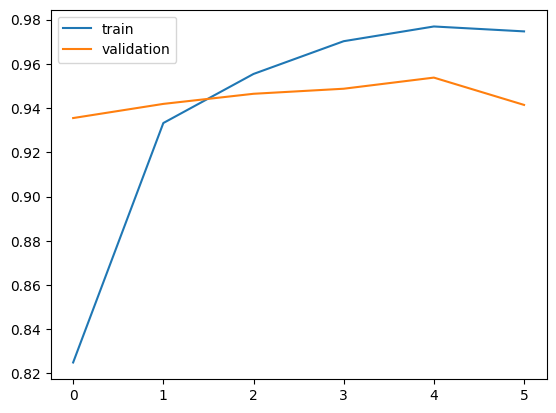

In [58]:
plt.plot(trainer.history['train-f1'],
         label = "train")
plt.plot(trainer.history['validation-f1'],
         label = "validation")

plt.legend()

In [59]:
trainer.history['validation-f1']

[0.9354986548423767,
 0.9419029355049133,
 0.9464775919914246,
 0.9487648606300354,
 0.9537968635559082,
 0.9414455890655518]

In [60]:
trainer.history['train-f1']

[0.8249354958534241,
 0.9332472681999207,
 0.9554465413093567,
 0.9702633023262024,
 0.9769230484962463,
 0.9747031331062317]